# Anomaly Detection using Logistic Regression

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score,roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
# Load Labelled Dataset
file_path = "/content/sample_data/Labelled_Data.csv"
df = pd.read_csv(file_path)

In [3]:
# Data exploration
print(df.info())
print(df["isFraud"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3684 entries, 0 to 3683
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            3684 non-null   int64  
 1   type            3684 non-null   object 
 2   amount          3684 non-null   float64
 3   nameOrig        3684 non-null   object 
 4   oldbalanceOrg   3684 non-null   float64
 5   newbalanceOrig  3684 non-null   float64
 6   nameDest        3684 non-null   object 
 7   oldbalanceDest  3684 non-null   float64
 8   newbalanceDest  3684 non-null   float64
 9   isFraud         3684 non-null   int64  
 10  isFlaggedFraud  3684 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 316.7+ KB
None
isFraud
0    3665
1      19
Name: count, dtype: int64


# There are only 19 fraud transactions, which is just 0.5% of the total data.

In [ ]:
# Encode categorical features
le = LabelEncoder()
df['type'] = df['type'].astype(str)
le.fit(df['type'])  # Fitting only known categories
joblib.dump(le, "label_encoder.pkl")
df['type'] = le.transform(df['type'])

In [5]:
# Feature Engineering
df['balance_diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diffDest'] = df['oldbalanceDest'] - df['newbalanceDest']

In [ ]:
# Selecting Relevant Features
features = ["type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "balance_diffOrig", "balance_diffDest"]
X = df[features]
y = df["isFraud"]

In [ ]:
# Handling Class Imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Handling class imbalance is essential as fraud transactions are only 0.5% of the total data.

In [ ]:
# Standardizing Data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
joblib.dump(scaler, "scaler.pkl")  # Save the scaler

['scaler.pkl']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
# Hyper-Parameter Tunning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear'],  # Solver for optimization
    'class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}]  # Class weights
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Getting best parameters and model
print("Best Parameters:", grid_search.best_params_)
log_reg = grid_search.best_estimator_

Best Parameters: {'C': 100, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Save the best model
joblib.dump(log_reg, "fraud_detection_log_reg_model.pkl")

['fraud_detection_log_reg_model.pkl']

In [12]:
# Predictions on test set
y_proba = log_reg.predict_proba(X_test)[:, 1]

In [15]:
# Find optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

y_pred = (y_proba > optimal_threshold).astype(int)

Optimal Threshold: 0.6673669863244548


In [16]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       733
           1       0.89      0.96      0.93       367

    accuracy                           0.95      1100
   macro avg       0.94      0.95      0.94      1100
weighted avg       0.95      0.95      0.95      1100

Confusion Matrix:
 [[690  43]
 [ 13 354]]
AUC-ROC Score: 0.9874168714290493


# A 0.98 ROC-AUC score means the model is performing extremely well, and will distinguish correctly between the classes with a 98% chance.

In [17]:
# Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)
print("Average Precision Score:", ap_score)

Average Precision Score: 0.9710762514260867


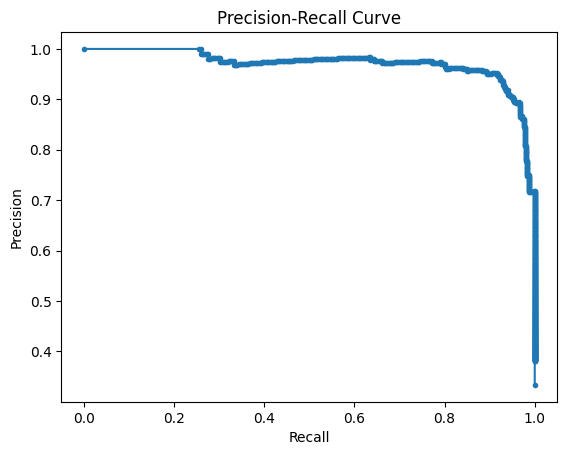

In [18]:
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# The model achieves high precision (0.9) only when recall is near zero, but precision drops sharply to 0.4 as recall reaches 1.0. This means that the model flags fraud accurately only when extremely cautious, but becomes unreliable when trying to catch most cases.

In [ ]:
# Load Unlabelled Dataset
file_path1 = "/content/sample_data/Unlabelled_Data.csv"
df_unlabeled = pd.read_csv(file_path1)

In [ ]:
# Load saved models
log_reg = joblib.load("fraud_detection_log_reg_model.pkl") # Load the Trained Model
le = joblib.load("label_encoder.pkl") # Load the Label Encoder
scaler = joblib.load("scaler.pkl")  # Load the scaler

In [ ]:
# Encoding Categorical Features
df_unlabeled['type'] = df_unlabeled['type'].astype(str)
known_categories = set(le.classes_)  # Get known categories
df_unlabeled['type'] = df_unlabeled['type'].apply(lambda x: x if x in known_categories else le.classes_[0])  # Assign first known category
df_unlabeled['type'] = le.transform(df_unlabeled['type'])

In [22]:
# Feature Engineering
df_unlabeled['balance_diffOrig'] = df_unlabeled['oldbalanceOrg'] - df_unlabeled['newbalanceOrig']
df_unlabeled['balance_diffDest'] = df_unlabeled['oldbalanceDest'] - df_unlabeled['newbalanceDest']

In [23]:
# Selecting relevant features
X_unlabeled = df_unlabeled[features]

In [24]:
# Standardizing the data
X_unlabeled = scaler.transform(X_unlabeled)

In [ ]:
# Predicting Fraud Cases
y_proba_unlabeled = log_reg.predict_proba(X_unlabeled)[:, 1]
y_pred_unlabeled = (y_proba_unlabeled > optimal_threshold).astype(int)

In [ ]:
# Add Predictions to the Dataset
df_unlabeled["isFraud_Predicted"] = y_pred_unlabeled

In [ ]:
# Save Results
df_unlabeled.to_csv("predicted_fraud_cases_log_reg.csv", index=False)